## HyperParameter Tuning

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets
import optuna
from torch.utils.data import DataLoader
import torch.nn.functional as F
from functools import partial
import timm
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import os
import json


In [21]:
import pandas as pd

# Load the CSV split files
train_df = pd.read_csv("datasets1/train_split.csv")
val_df = pd.read_csv("datasets1/val_split.csv")
test_df = pd.read_csv("datasets1/test_split.csv")

# Function to get distribution as DataFrame
def get_distribution(df, split_name):
    count = df['label'].value_counts().rename(f'{split_name}_count')
    return pd.concat([count], axis=1)

# Combine distributions into a single table
train_dist = get_distribution(train_df, 'train')
val_dist = get_distribution(val_df, 'val')
test_dist = get_distribution(test_df, 'test')

distribution_table = pd.concat([train_dist, val_dist, test_dist], axis=1).fillna(0)
distribution_table = distribution_table.sort_index()  # Optional: sort by label

# Display the table
print("\n=== Dataset Class Distribution ===\n")
print(distribution_table.to_string())


=== Dataset Class Distribution ===

           train_count  val_count  test_count
label                                        
NORMAL            1108        237         238
PNEUMONIA         2991        641         641



=== Train ===


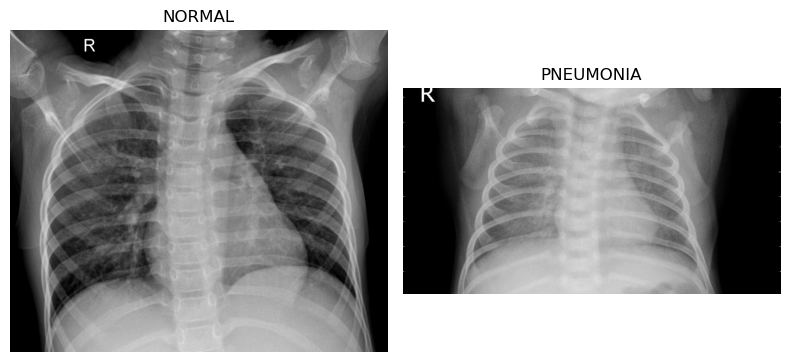


=== Validation ===


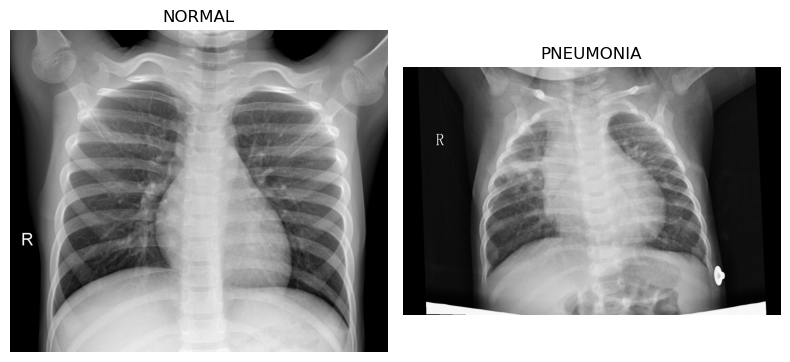


=== Test ===


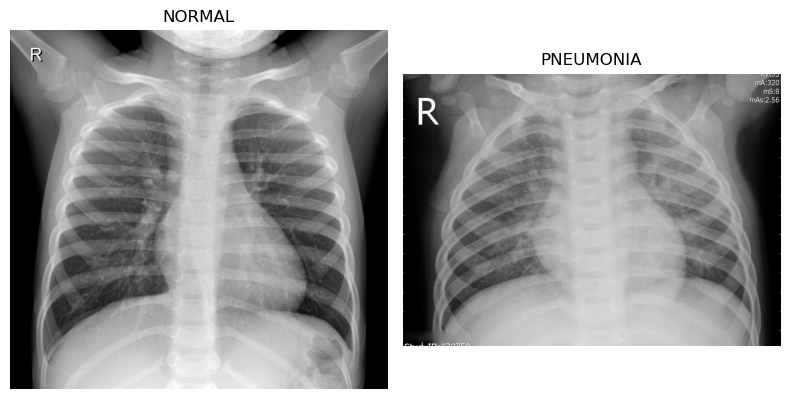

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load splits
splits = {
    "Train": pd.read_csv("datasets1/train_split.csv"),
    "Validation": pd.read_csv("datasets1/val_split.csv"),
    "Test": pd.read_csv("datasets1/test_split.csv")
}

for split_name, df in splits.items():
    print(f"\n=== {split_name} ===")
    classes = df['label'].unique()
    
    fig, axs = plt.subplots(1, len(classes), figsize=(len(classes)*4, 4))
    if len(classes) == 1:
        axs = [axs]
        
    for ax, label in zip(axs, sorted(classes)):
        sample = df[df['label'] == label].iloc[0]
        img = mpimg.imread(sample['filepath'])
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def define_model(model_name):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif model_name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, 2)
    elif model_name == "vit_b_16":
        model = timm.create_model("vit_base_patch16_224", pretrained=True)
        model.head = nn.Linear(model.head.in_features, 2)
    elif model_name == "swin_t":
        model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=2)
    return model

def objective(trial, model_name):
    # Build model
    model = define_model(model_name).to(device)

    # Hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    
    # Load & transform data
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),  
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    val_transform  = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    train_dataset = datasets.ImageFolder("datasets1/train", transform=train_transform)
    val_dataset = datasets.ImageFolder("datasets1/val", transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
 
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(5):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss =  loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation at each epoch for pruning
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_f1 = f1_score(all_labels, all_preds, average='macro')
        
        # Report to Optuna
        trial.report(epoch_f1, epoch)

        # Check if trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Validation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate macro F1 score
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return macro_f1

for model_name in ["resnet50", "densenet121", "vit_b_16", "swin_t"]:
    print(f"Running Optuna study for {model_name}")

    storage = f"sqlite:///hyperparameter/optuna_{model_name}.sqlite"

    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)

    study = optuna.create_study(direction="maximize", study_name=model_name, storage=storage, load_if_exists=True, pruner=pruner)
    
    print(f"Trials already completed: {len(study.trials)}")
    
    if len(study.trials) < 20:
        study.optimize(partial(objective, model_name=model_name), n_trials=20 - len(study.trials))

    # Save or print results
    print(f"Best trial for {model_name}:")
    print(study.best_trial)

    optuna.visualization.plot_optimization_history(study).show()
    optuna.visualization.plot_param_importances(study).show()

[I 2025-06-16 12:18:25,116] Using an existing study with name 'resnet50' instead of creating a new one.


Running Optuna study for resnet50
Trials already completed: 20
Best trial for resnet50:
FrozenTrial(number=4, state=1, values=[0.9698569357003546], datetime_start=datetime.datetime(2025, 5, 23, 21, 11, 49, 385081), datetime_complete=datetime.datetime(2025, 5, 23, 21, 15, 47, 434062), params={'lr': 1.498373288754048e-05, 'optimizer': 'AdamW', 'weight_decay': 3.7033578598116267e-05, 'batch_size': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=('Adam', 'AdamW', 'SGD')), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=5, value=None)


[I 2025-06-16 12:18:25,236] Using an existing study with name 'densenet121' instead of creating a new one.


Running Optuna study for densenet121
Trials already completed: 20
Best trial for densenet121:
FrozenTrial(number=11, state=1, values=[0.9686249285305889], datetime_start=datetime.datetime(2025, 5, 24, 12, 3, 46, 174281), datetime_complete=datetime.datetime(2025, 5, 24, 15, 17, 26, 346298), params={'lr': 1.4194034200960504e-05, 'optimizer': 'Adam', 'weight_decay': 0.00013578785477404116, 'batch_size': 16}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.9184318097361576, 1: 0.9523825958338469, 2: 0.9604014973465695, 3: 0.9700126370436148, 4: 0.9686249285305889}, distributions={'lr': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=('Adam', 'AdamW', 'SGD')), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=12, value=None)


Running Optuna study for vit_b_16


[I 2025-06-16 12:18:25,578] Using an existing study with name 'vit_b_16' instead of creating a new one.


Trials already completed: 20
Best trial for vit_b_16:
FrozenTrial(number=1, state=1, values=[0.972362629079047], datetime_start=datetime.datetime(2025, 5, 25, 6, 15, 35, 246064), datetime_complete=datetime.datetime(2025, 5, 25, 8, 23, 6, 97947), params={'lr': 1.1929012198058597e-05, 'optimizer': 'AdamW', 'weight_decay': 0.00021486081756609646, 'batch_size': 16}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.9538880389794988, 1: 0.9522337429595493, 2: 0.9721343870216601, 3: 0.8951163047406487, 4: 0.972362629079047}, distributions={'lr': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=('Adam', 'AdamW', 'SGD')), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=2, value=None)


[I 2025-06-16 12:18:25,718] Using an existing study with name 'swin_t' instead of creating a new one.


Running Optuna study for swin_t
Trials already completed: 20
Best trial for swin_t:
FrozenTrial(number=17, state=1, values=[0.9671566977144352], datetime_start=datetime.datetime(2025, 5, 26, 6, 21, 16, 650888), datetime_complete=datetime.datetime(2025, 5, 26, 6, 32, 44, 633784), params={'lr': 4.2766053119665225e-05, 'optimizer': 'AdamW', 'weight_decay': 0.00022175793633331478, 'batch_size': 16}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.9537545344105478, 1: 0.9589916728942031, 2: 0.9641153996432792, 3: 0.962728578892372, 4: 0.9671566977144352}, distributions={'lr': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=('Adam', 'AdamW', 'SGD')), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=18, value=None)


## Training

In [24]:
def train_with_early_stopping(model_name, db_path, max_epochs=30, patience=5):
    study = optuna.load_study(study_name=model_name, storage=f"sqlite:///{db_path}")
    best_params = study.best_trial.params

    print("Best hyperparameters:", best_params)

    # Build model
    model = define_model(model_name).to(device)

    # Load & transform data
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),  
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    val_transform  = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    train_dataset = datasets.ImageFolder("datasets1/train", transform=train_transform)
    val_dataset = datasets.ImageFolder("datasets1/val", transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])

    # Optimizer
    if best_params['optimizer'] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    elif best_params['optimizer'] == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=best_params['lr'], momentum=0.9, weight_decay=best_params['weight_decay'])

    loss_fn = nn.CrossEntropyLoss()

    # Early stopping setup
    best_val_loss = float('inf')
    patience_counter = 0

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(max_epochs):
        model.train()
        total_train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Check early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"models/best_{model_name}.pt")
            print("Best model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    os.makedirs("history", exist_ok=True)
    with open(f"history/{model_name}_loss_history.json", "w") as f:
        json.dump(history, f)

    print("Finished Training")



for model_name in ["resnet50", "densenet121", "vit_b_16", "swin_t"]:
    model_path = f"models/best_{model_name}.pt"

    if os.path.exists(model_path):
        print(f"{model_name} already trained. Skipping...")
        continue

    print(f"Started training for {model_name}")
    train_with_early_stopping(model_name, f"hyperparameter/optuna_{model_name}.sqlite")


Started training for resnet50
Best hyperparameters: {'lr': 1.498373288754048e-05, 'optimizer': 'AdamW', 'weight_decay': 3.7033578598116267e-05, 'batch_size': 32}


c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



Epoch 1, Train Loss: 0.2848, Validation Loss: 0.1663
Best model saved.
Epoch 2, Train Loss: 0.1050, Validation Loss: 0.0924
Best model saved.
Epoch 3, Train Loss: 0.0902, Validation Loss: 0.0857
Best model saved.
Epoch 4, Train Loss: 0.0849, Validation Loss: 0.1064
Epoch 5, Train Loss: 0.0832, Validation Loss: 0.0779
Best model saved.
Epoch 6, Train Loss: 0.0646, Validation Loss: 0.0772
Best model saved.
Epoch 7, Train Loss: 0.0677, Validation Loss: 0.0726
Best model saved.
Epoch 8, Train Loss: 0.0530, Validation Loss: 0.0725
Best model saved.
Epoch 9, Train Loss: 0.0401, Validation Loss: 0.0728
Epoch 10, Train Loss: 0.0391, Validation Loss: 0.0893
Epoch 11, Train Loss: 0.0264, Validation Loss: 0.0947
Epoch 12, Train Loss: 0.0409, Validation Loss: 0.1030
Epoch 13, Train Loss: 0.0279, Validation Loss: 0.0779
Early stopping at epoch 13
Finished Training
Started training for densenet121
Best hyperparameters: {'lr': 1.4194034200960504e-05, 'optimizer': 'Adam', 'weight_decay': 0.00013578785

c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.



Epoch 1, Train Loss: 0.2522, Validation Loss: 0.1568
Best model saved.
Epoch 2, Train Loss: 0.1412, Validation Loss: 0.1044
Best model saved.
Epoch 3, Train Loss: 0.1089, Validation Loss: 0.0827
Best model saved.
Epoch 4, Train Loss: 0.0946, Validation Loss: 0.0763
Best model saved.
Epoch 5, Train Loss: 0.0850, Validation Loss: 0.0799
Epoch 6, Train Loss: 0.0742, Validation Loss: 0.0671
Best model saved.
Epoch 7, Train Loss: 0.0743, Validation Loss: 0.0698
Epoch 8, Train Loss: 0.0593, Validation Loss: 0.0740
Epoch 9, Train Loss: 0.0602, Validation Loss: 0.0834
Epoch 10, Train Loss: 0.0466, Validation Loss: 0.0799
Epoch 11, Train Loss: 0.0404, Validation Loss: 0.0678
Early stopping at epoch 11
Finished Training
Started training for vit_b_16
Best hyperparameters: {'lr': 1.1929012198058597e-05, 'optimizer': 'AdamW', 'weight_decay': 0.00021486081756609646, 'batch_size': 16}
Epoch 1, Train Loss: 0.1854, Validation Loss: 0.1150
Best model saved.
Epoch 2, Train Loss: 0.0896, Validation Loss: 

## Testing

c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.




Evaluating resnet50...

resnet50 Classification Report:
   Metric    Score
 Accuracy 0.961320
Precision 0.961948
   Recall 0.985959
 F1-Score 0.973806
  AUC-ROC 0.995379

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9595    0.8950    0.9261       238
           1     0.9619    0.9860    0.9738       641

    accuracy                         0.9613       879
   macro avg     0.9607    0.9405    0.9499       879
weighted avg     0.9613    0.9613    0.9609       879



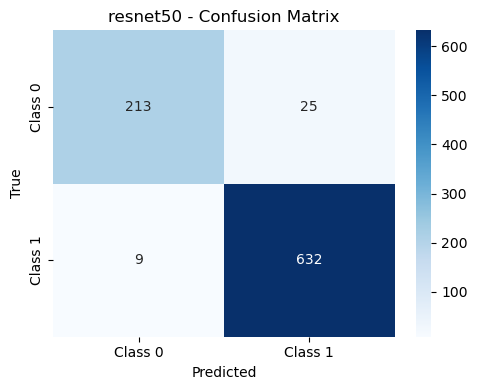

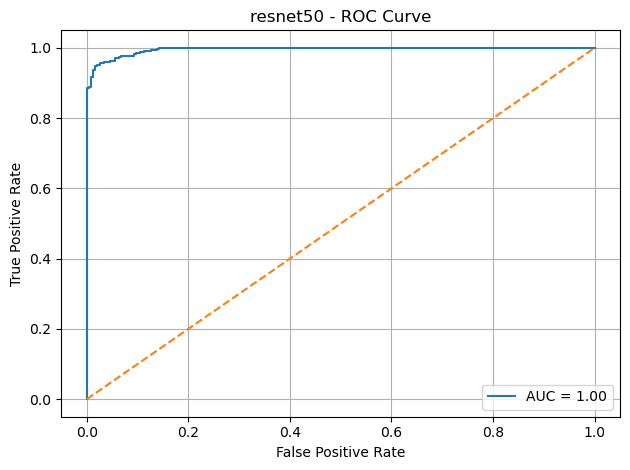

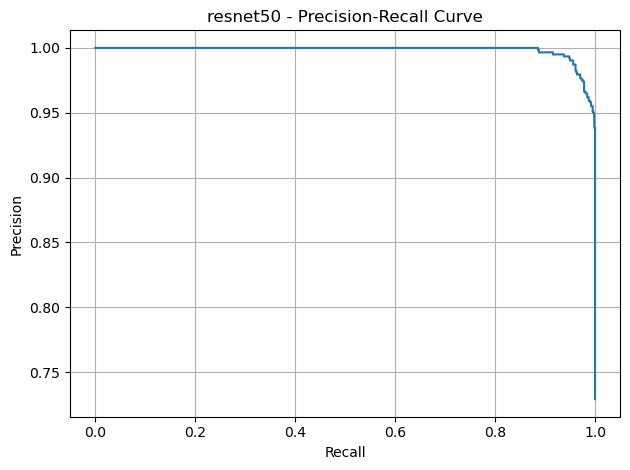


Evaluating densenet121...


c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.




densenet121 Classification Report:
   Metric    Score
 Accuracy 0.974972
Precision 0.978362
   Recall 0.987520
 F1-Score 0.982919
  AUC-ROC 0.995307

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9655    0.9412    0.9532       238
           1     0.9784    0.9875    0.9829       641

    accuracy                         0.9750       879
   macro avg     0.9719    0.9643    0.9681       879
weighted avg     0.9749    0.9750    0.9749       879



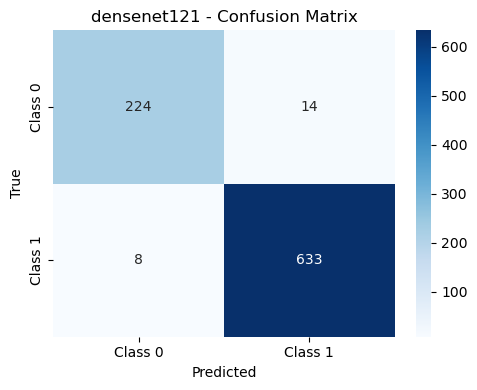

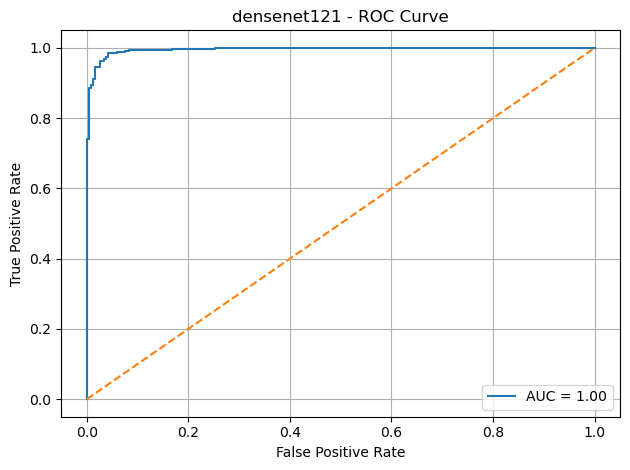

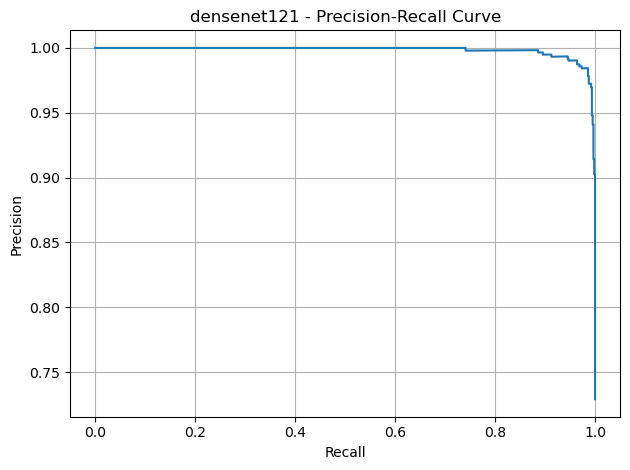


Evaluating vit_b_16...

vit_b_16 Classification Report:
   Metric    Score
 Accuracy 0.968146
Precision 0.975194
   Recall 0.981279
 F1-Score 0.978227
  AUC-ROC 0.994913

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9487    0.9328    0.9407       238
           1     0.9752    0.9813    0.9782       641

    accuracy                         0.9681       879
   macro avg     0.9620    0.9570    0.9595       879
weighted avg     0.9680    0.9681    0.9681       879



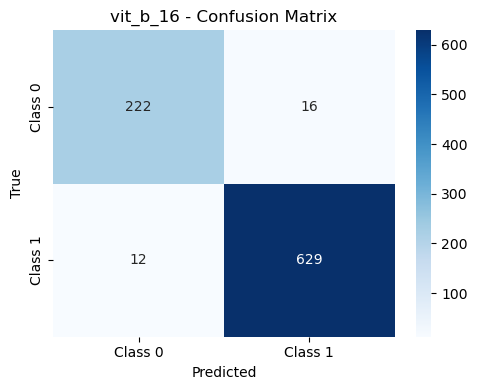

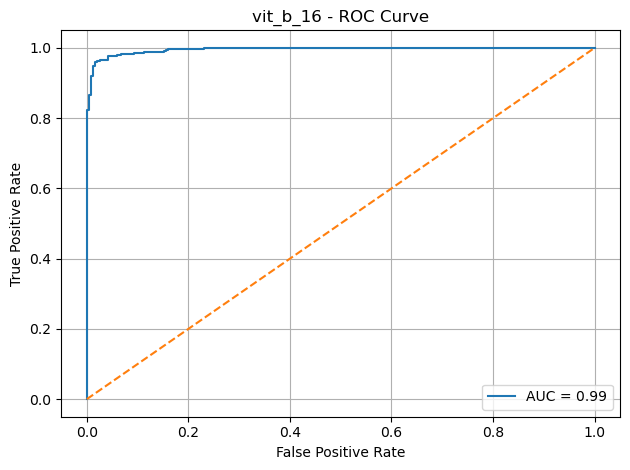

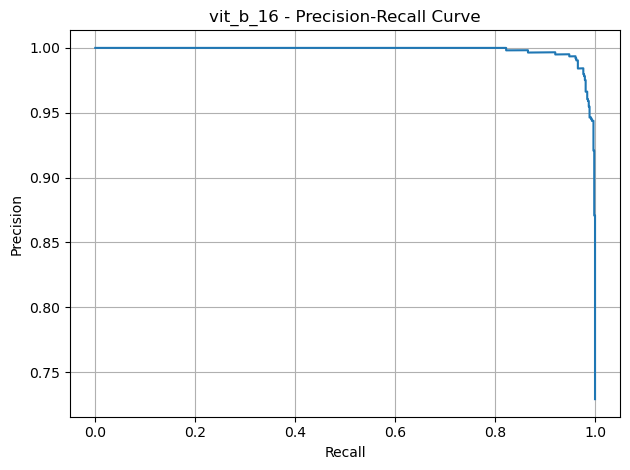


Evaluating swin_t...

swin_t Classification Report:
   Metric    Score
 Accuracy 0.968146
Precision 0.970814
   Recall 0.985959
 F1-Score 0.978328
  AUC-ROC 0.996172

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9605    0.9202    0.9399       238
           1     0.9708    0.9860    0.9783       641

    accuracy                         0.9681       879
   macro avg     0.9657    0.9531    0.9591       879
weighted avg     0.9680    0.9681    0.9679       879



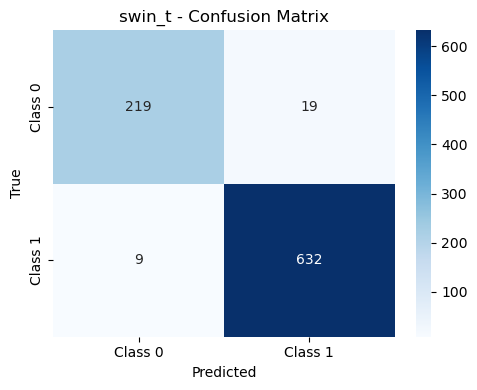

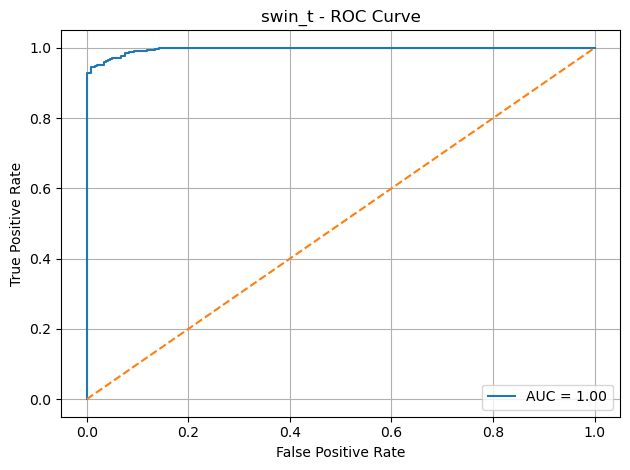

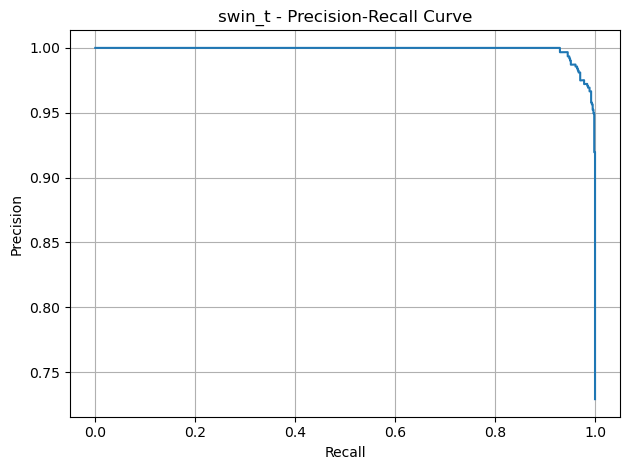

In [31]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_model(model_name):
    print(f"\nEvaluating {model_name}...")

    # Load model
    model = define_model(model_name).to(device)
    model.load_state_dict(torch.load(f"models/best_{model_name}.pt"))
    model.eval()

    # Data transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    test_dataset = datasets.ImageFolder("datasets1/test", transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_pr_curve(y_true, y_probs, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.figure()
    plt.plot(recall, precision, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.grid()
    plt.tight_layout()
    plt.show()

def generate_report(y_true, y_pred, y_probs, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)

    # Create metrics table
    df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"],
        "Score": [acc, prec, rec, f1, auc]
    })
    print(f"\n{model_name} Classification Report:")
    print(df.to_string(index=False))
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    return df

# Loop through all models
for model_name in ["resnet50", "densenet121", "vit_b_16", "swin_t"]:
    y_true, y_pred, y_probs = evaluate_model(model_name)
    metrics_df = generate_report(y_true, y_pred, y_probs, model_name)
    plot_conf_matrix(y_true, y_pred, model_name)
    plot_roc_curve(y_true, y_probs, model_name)
    plot_pr_curve(y_true, y_probs, model_name)

In [28]:
def train_without_tuning(model_name, max_epochs=30, patience=5):
    print(f"Training {model_name} without hyperparameter tuning...")

    # Fixed/default hyperparameters
    batch_size = 32
    learning_rate = 1e-3
    weight_decay = 1e-4
    optimizer_choice = "Adam"

    # Define model
    model = define_model(model_name).to(device)

    # Load & transform data
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),  
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    val_transform  = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    train_dataset = datasets.ImageFolder("datasets1/train", transform=train_transform)
    val_dataset = datasets.ImageFolder("datasets1/val", transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Optimizer
    if optimizer_choice == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

    loss_fn = nn.CrossEntropyLoss()

    # Early stopping setup
    best_val_loss = float('inf')
    patience_counter = 0
    
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(max_epochs):
        model.train()
        total_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Check early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"models/best_notune_{model_name}.pt")
            print("Best model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    os.makedirs("history", exist_ok=True)
    with open(f"history/{model_name}_notune_loss_history.json", "w") as f:
        json.dump(history, f)

    print("Finished training for", model_name)


for model_name in ["resnet50", "densenet121", "vit_b_16", "swin_t"]:
    model_path = f"models/best_notune_{model_name}.pt"

    if os.path.exists(model_path):
        print(f"{model_name} already trained. Skipping...")
        continue

    print(f"Started training for {model_name}")
    train_without_tuning(model_name)


Started training for resnet50
Training resnet50 without hyperparameter tuning...


c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



Epoch 1, Train Loss: 0.2078, Validation Loss: 0.1160
Best model saved.
Epoch 2, Train Loss: 0.1650, Validation Loss: 0.1551
Epoch 3, Train Loss: 0.1638, Validation Loss: 0.1413
Epoch 4, Train Loss: 0.1532, Validation Loss: 0.1911
Epoch 5, Train Loss: 0.1652, Validation Loss: 0.1316
Epoch 6, Train Loss: 0.1397, Validation Loss: 0.3897
Early stopping at epoch 6
Finished training for resnet50
Started training for densenet121
Training densenet121 without hyperparameter tuning...


c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.



Epoch 1, Train Loss: 0.1841, Validation Loss: 0.2737
Best model saved.
Epoch 2, Train Loss: 0.1378, Validation Loss: 0.1044
Best model saved.
Epoch 3, Train Loss: 0.1261, Validation Loss: 0.3373
Epoch 4, Train Loss: 0.1326, Validation Loss: 0.2896
Epoch 5, Train Loss: 0.1324, Validation Loss: 0.2691
Epoch 6, Train Loss: 0.1164, Validation Loss: 0.1245
Epoch 7, Train Loss: 0.1044, Validation Loss: 0.1258
Early stopping at epoch 7
Finished training for densenet121
Started training for vit_b_16
Training vit_b_16 without hyperparameter tuning...
Epoch 1, Train Loss: 0.8216, Validation Loss: 0.5375
Best model saved.
Epoch 2, Train Loss: 0.5240, Validation Loss: 0.4773
Best model saved.
Epoch 3, Train Loss: 0.4904, Validation Loss: 0.4010
Best model saved.
Epoch 4, Train Loss: 0.3953, Validation Loss: 0.5067
Epoch 5, Train Loss: 0.3712, Validation Loss: 0.4117
Epoch 6, Train Loss: 0.3710, Validation Loss: 0.8720
Epoch 7, Train Loss: 0.4916, Validation Loss: 0.3262
Best model saved.
Epoch 8, 


Evaluating resnet50 default...


c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.




resnet50 Classification Report:
   Metric    Score
 Accuracy 0.940842
Precision 0.974235
   Recall 0.943838
 F1-Score 0.958796
  AUC-ROC 0.983868

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.8605    0.9328    0.8952       238
           1     0.9742    0.9438    0.9588       641

    accuracy                         0.9408       879
   macro avg     0.9174    0.9383    0.9270       879
weighted avg     0.9434    0.9408    0.9416       879



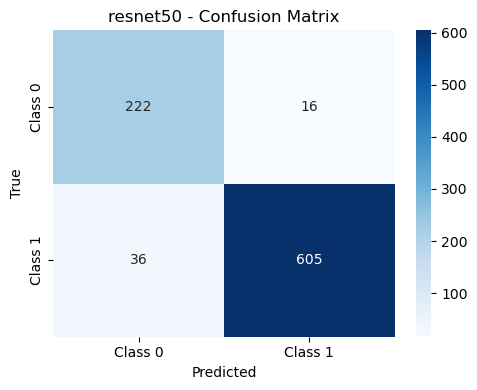

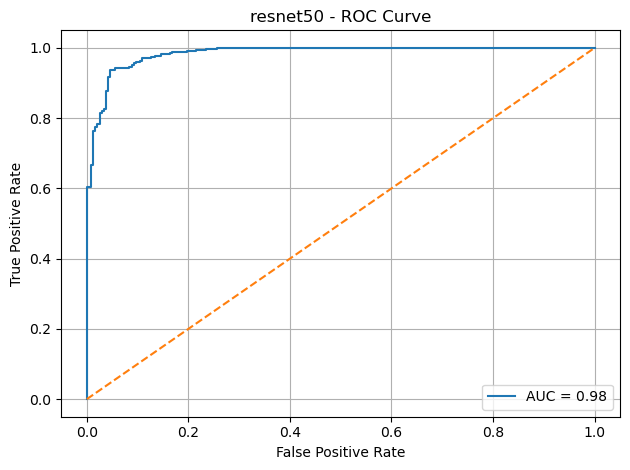

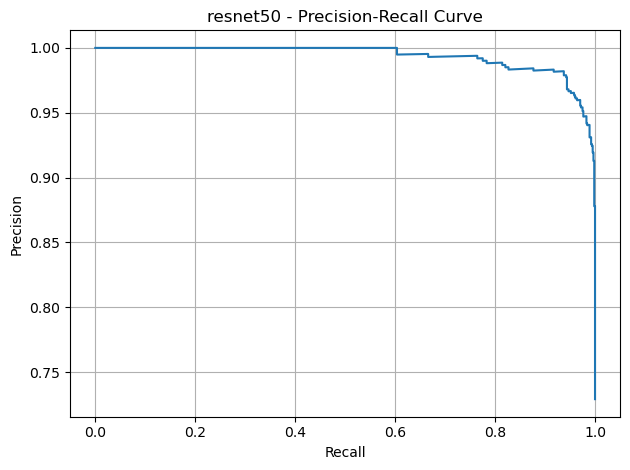


Evaluating densenet121 default...


c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

c:\Users\aklem\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.




densenet121 Classification Report:
   Metric    Score
 Accuracy 0.947668
Precision 0.956989
   Recall 0.971919
 F1-Score 0.964396
  AUC-ROC 0.989152

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9211    0.8824    0.9013       238
           1     0.9570    0.9719    0.9644       641

    accuracy                         0.9477       879
   macro avg     0.9390    0.9271    0.9328       879
weighted avg     0.9473    0.9477    0.9473       879



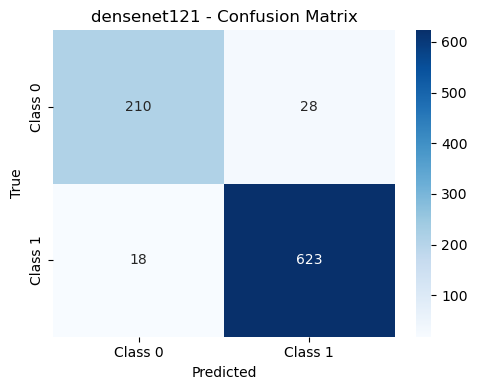

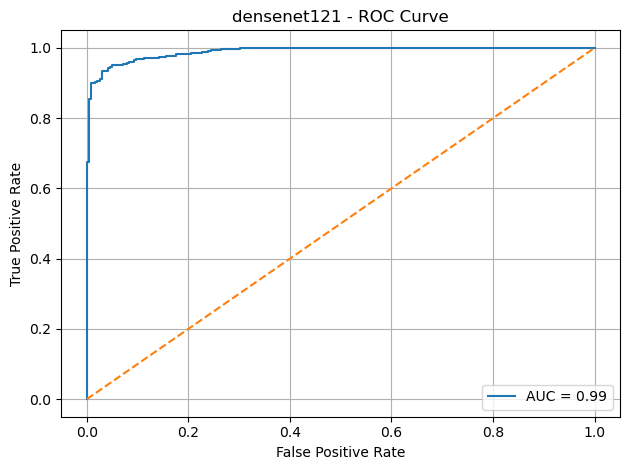

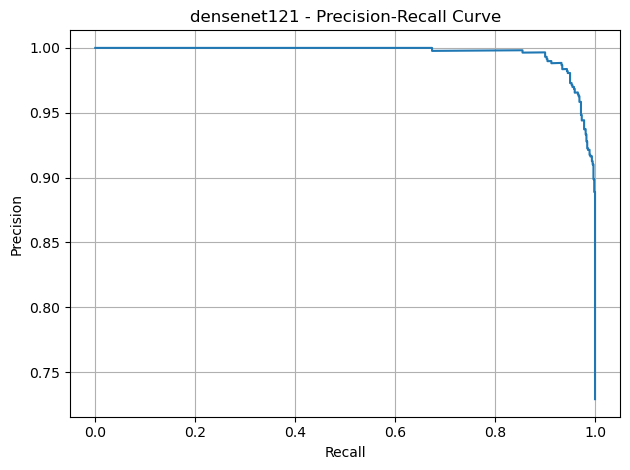


Evaluating vit_b_16 default...

vit_b_16 Classification Report:
   Metric    Score
 Accuracy 0.906712
Precision 0.920301
   Recall 0.954758
 F1-Score 0.937213
  AUC-ROC 0.963712

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.8645    0.7773    0.8186       238
           1     0.9203    0.9548    0.9372       641

    accuracy                         0.9067       879
   macro avg     0.8924    0.8660    0.8779       879
weighted avg     0.9052    0.9067    0.9051       879



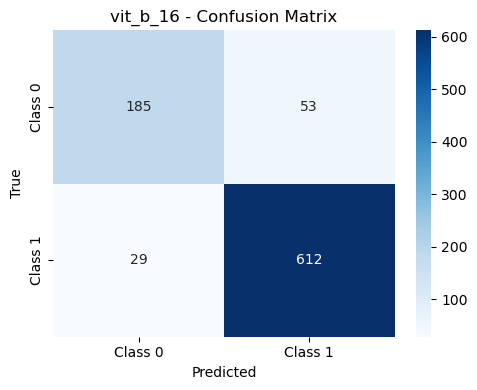

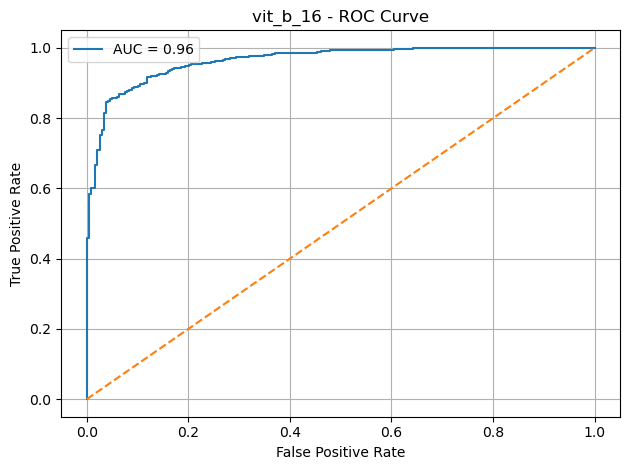

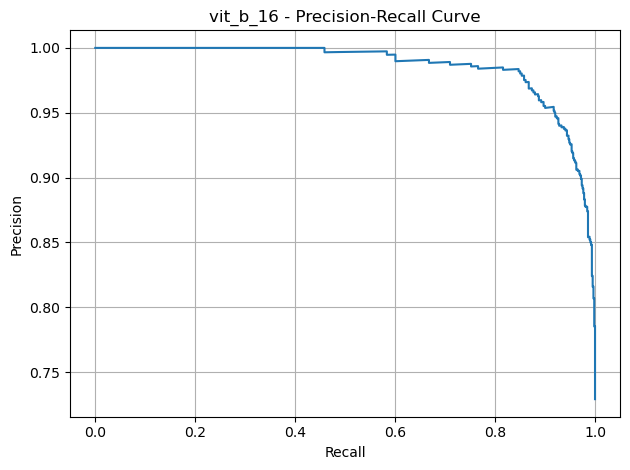


Evaluating swin_t default...

swin_t Classification Report:
   Metric    Score
 Accuracy 0.729238
Precision 0.729238
   Recall 1.000000
 F1-Score 0.843421
  AUC-ROC 0.661716

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       238
           1     0.7292    1.0000    0.8434       641

    accuracy                         0.7292       879
   macro avg     0.3646    0.5000    0.4217       879
weighted avg     0.5318    0.7292    0.6151       879



c:\Users\aklem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\aklem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\aklem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



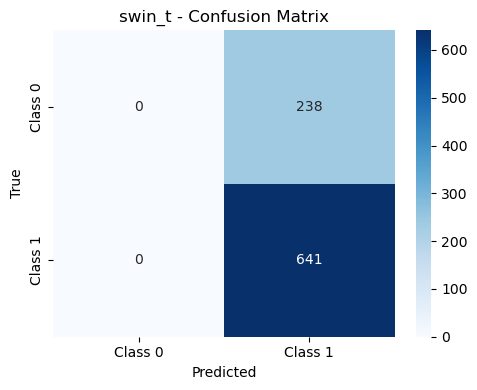

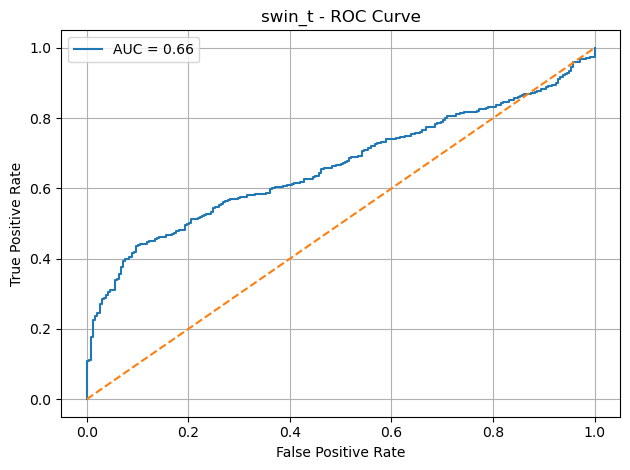

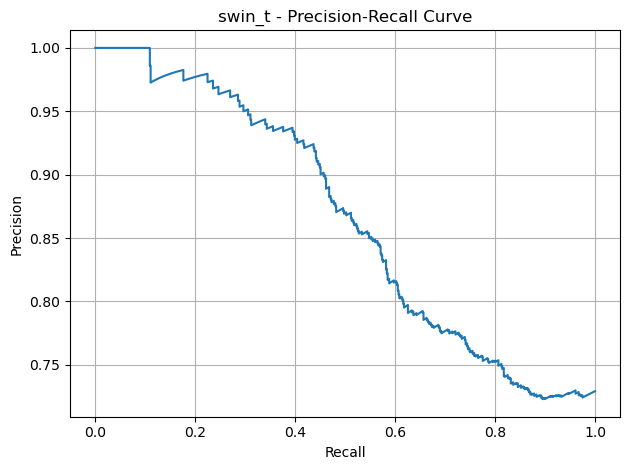

In [30]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_model(model_name):
    print(f"\nEvaluating {model_name} default...")

    # Load model
    model = define_model(model_name).to(device)
    model.load_state_dict(torch.load(f"models/best_notune_{model_name}.pt"))
    model.eval()

    # Data transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    test_dataset = datasets.ImageFolder("datasets1/test", transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_pr_curve(y_true, y_probs, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.figure()
    plt.plot(recall, precision, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.grid()
    plt.tight_layout()
    plt.show()

def generate_report(y_true, y_pred, y_probs, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)

    # Create metrics table
    df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"],
        "Score": [acc, prec, rec, f1, auc]
    })
    print(f"\n{model_name} Classification Report:")
    print(df.to_string(index=False))
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    return df

# Loop through all models
for model_name in ["resnet50", "densenet121", "vit_b_16", "swin_t"]:
    y_true, y_pred, y_probs = evaluate_model(model_name)
    metrics_df = generate_report(y_true, y_pred, y_probs, model_name)
    plot_conf_matrix(y_true, y_pred, model_name)
    plot_roc_curve(y_true, y_probs, model_name)
    plot_pr_curve(y_true, y_probs, model_name)

resnet50 (notuned) {'train_loss': [0.20780174613229987, 0.16496994232311268, 0.16382969489913116, 0.15321855119956557, 0.16521380886493264, 0.13974224883781441], 'val_loss': [0.1160495183929535, 0.15510810895024665, 0.14129676197522453, 0.1910972871145142, 0.13159568617369846, 0.3896996745440577]}
resnet50 (tuned) {'train_loss': [0.2848324353496234, 0.10503757226302526, 0.0902238884460643, 0.08489479043687037, 0.08324421455636043, 0.06461261027644194, 0.06771526909243791, 0.05297178499285103, 0.040102388385354806, 0.0390868513346758, 0.026368431833594344, 0.040913786235547, 0.027878029571571785], 'val_loss': [0.1663068352416823, 0.09243553861909147, 0.08572285298890035, 0.10642015646278326, 0.07791215992931809, 0.07720605177538735, 0.07262830543705993, 0.07247121872621522, 0.07278442287601397, 0.08928543730871752, 0.09474453951952455, 0.10301854084329014, 0.07794246149465575]}
densenet121 (notuned) {'train_loss': [0.1840817442582559, 0.1377818452324285, 0.1260880171862799, 0.1325902415

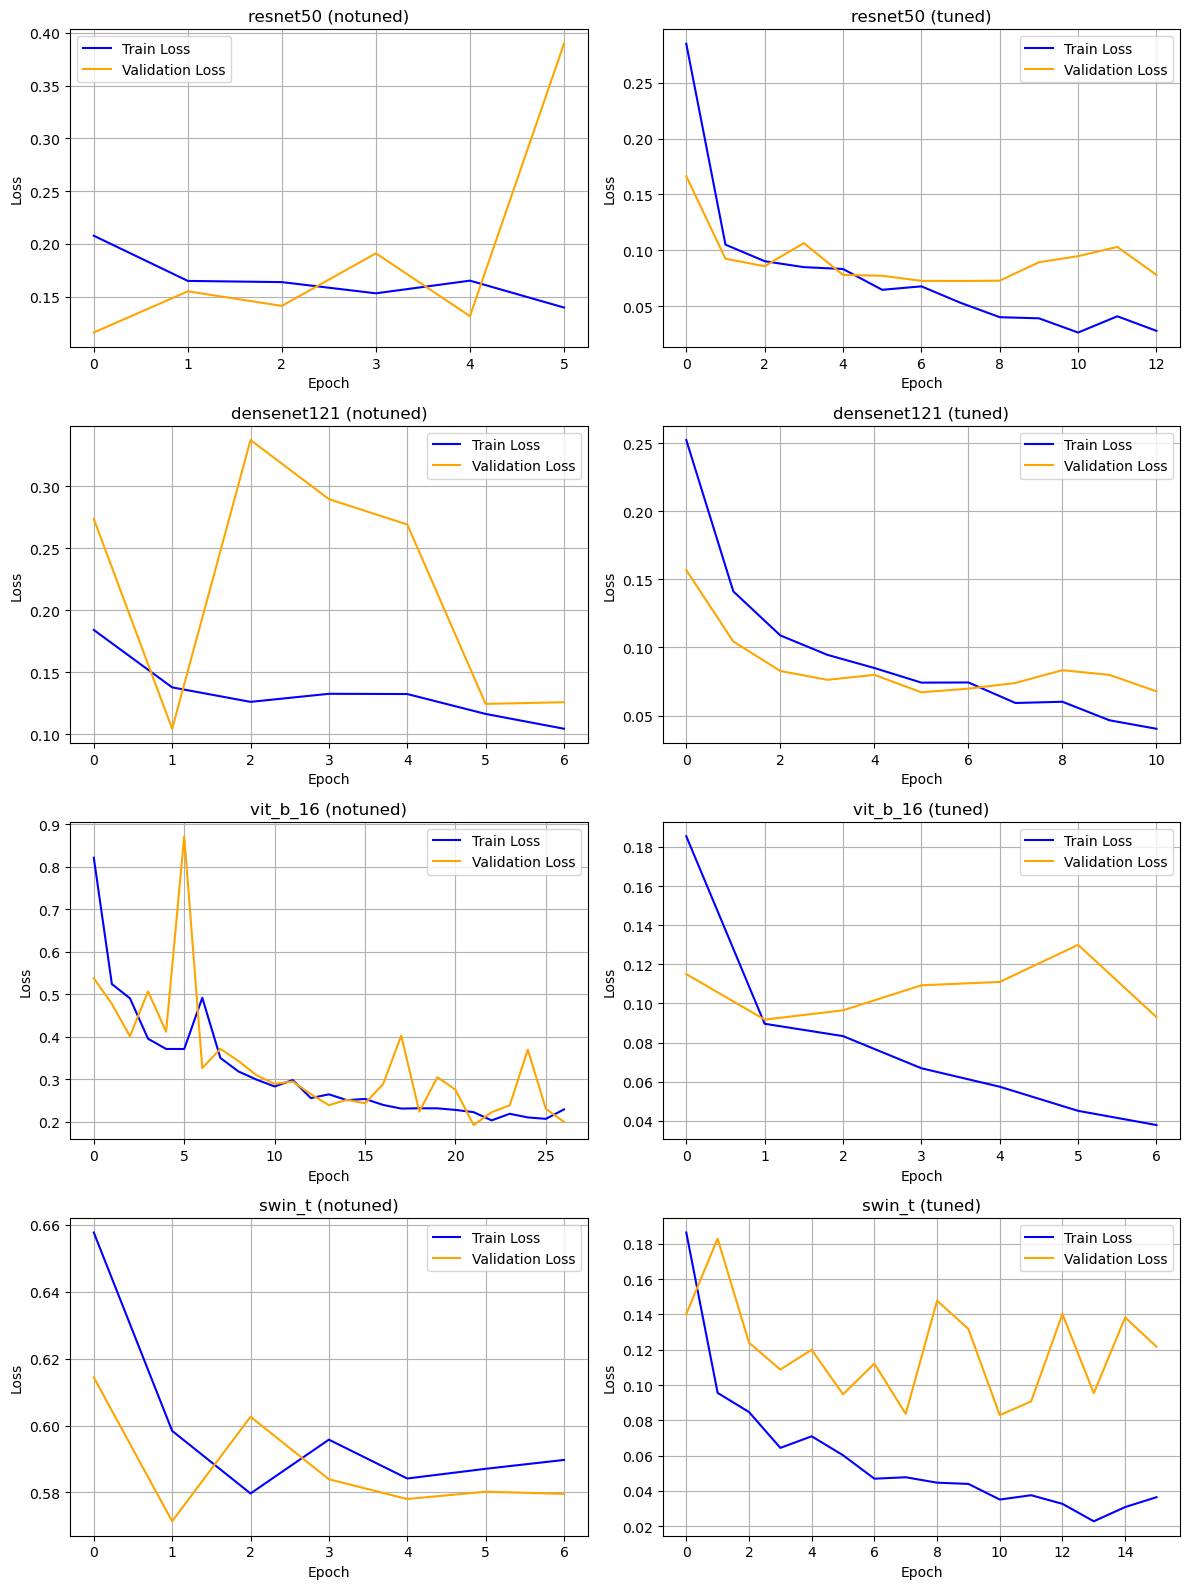

In [33]:
import json
import matplotlib.pyplot as plt
import os

model_names = ["resnet50", "densenet121", "vit_b_16", "swin_t"]

fig, axes = plt.subplots(nrows=len(model_names), ncols=2, figsize=(12, 4 * len(model_names)))

for i, model_name in enumerate(model_names):
    for j, version in enumerate(["notune", "tune"]):
        ax = axes[i, j]

        # Determine the correct filename
        if version == "tune":
            history_file = f"history/{model_name}_loss_history.json"
            title = f"{model_name} (tuned)"
        else:
            history_file = f"history/{model_name}_notune_loss_history.json"
            title = f"{model_name} (notuned)"

        # Check if file exists
        if os.path.exists(history_file):
            with open(history_file, "r") as f:
                history = json.load(f)

            ax.plot(history["train_loss"], label="Train Loss", color="blue")
            ax.plot(history["val_loss"], label="Validation Loss", color="orange")
            ax.set_title(title)
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.legend()
            ax.grid(True)

            print(title, history)
        else:
            ax.set_title(f"{title} (No data)")
            ax.axis("off")

plt.tight_layout()
plt.show()
